In [ ]:
!pip install kaggle

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d hbaflast/french-twitter-sentiment-analysis

In [ ]:
!unzip /content/french-twitter-sentiment-analysis.zip

In [1]:
import collections
import numpy as np # linear algebra
import pandas as pd # data processing
import os
#For Preprocessing
import re    # RegEx for removing non-letter characters
import nltk  #natural language processing
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *
# For Building the model
from sklearn.model_selection import train_test_split
import tensorflow as tf

import seaborn as sns
#For data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
pd.options.plotting.backend = "plotly"
from transformers import TFDistilBertForSequenceClassification, DistilBertConfig, DistilBertTokenizerFast
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import RandomOverSampler

from keras.models import Model
from keras.models import Sequential
from keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional,Dropout, LSTM
from keras.layers import Embedding
from tensorflow.keras.metrics import Precision, Recall



import nltk
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from unidecode import unidecode
import string
import re
from itertools import filterfalse
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
!pip install unidecode
!pip install spacy
!python -m spacy download fr_core_news_sm

In [ ]:
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score

In [4]:
df1=pd.read_csv(r'/kaggle/input/french-twitter-sentiment-analysis/french_tweets.csv')

In [ ]:
df1.head()

In [ ]:
df1['label'].value_counts()

In [ ]:
df1.columns

In [11]:

nltk.download('stopwords')

STOPWORDS_FRENCH = set(stopwords.words('french'))
stemmer = SnowballStemmer('french')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:


nltk.download('stopwords')
#nltk.download('wordnet',download_dir='/content/nltk_data/')  # Add this line to download WordNet

STOPWORDS_FRENCH = set(stopwords.words('french'))


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df1.columns

In [ ]:
data.dtypes


In [25]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
#oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
#X_resampled, y_resampled = oversampler.fit_resample(preproc_french_sentences, label)

In [ ]:
#X_resampled
#count_class_0 = y_resampled.tolist().count(0)
#count_class_0
#count_class_1 = y_resampled.tolist().count(1)
#count_class_1

In [13]:
corpus=[]
for i in range(len(df1['text'])):
    sentence = df1['text'][i].lower()
    sentence = re.sub(r'[^a-zA-Z0-9]', ' ', sentence)
    sentence = unidecode(sentence)
    sentence = sentence.replace("https://", "").replace("http://", "")
    sentence = sentence.replace("@", "")
    sentence = sentence.translate(str.maketrans("", "", "\t"))
    sentence = sentence.translate(str.maketrans("", "", "\n"))
    sentence = " ".join([word for word in sentence.split()])
    corpus.append(sentence)

In [15]:
from tensorflow.keras.preprocessing.text import one_hot
vocab_size=5000
onehot_repr=[one_hot(words,vocab_size)for words in corpus]

In [17]:
lo=[]
for i in range(len(onehot_repr)):
    lo.append(len(onehot_repr[i]))
lit=max(lo)

In [18]:
sent_length=lit
embedded_docs=pad_sequences(onehot_repr,padding='post',maxlen=sent_length)


In [34]:
embedding_vector_features=80
model=Sequential()
model.add(Embedding(vocab_size,embedding_vector_features,input_length=sent_length))
model.add(LSTM(8 , return_sequences=True))
model.add(Bidirectional(LSTM(4)))
model.add(Dense(4 , activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 85, 80)            400000    
                                                                 
 lstm_4 (LSTM)               (None, 85, 8)             2848      
                                                                 
 bidirectional_2 (Bidirecti  (None, 8)                 416       
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 4)                 36        
                                                                 
 dropout_2 (Dropout)         (None, 4)                 0         
                                                                 
 dense_5 (Dense)             (None, 1)                 5         
                                                      

In [35]:
label=df1['label']

In [36]:
import numpy as np
X_final=np.array(embedded_docs)
y_final=np.array(label)

In [37]:
model.compile(optimizer=Adam(0.001) , loss='binary_crossentropy' , metrics=['accuracy', Precision(name = 'precision'), Recall(name = 'recall')])

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [41]:
history = model.fit(
    X_train ,
    y_train ,
    batch_size=572 ,
    epochs=20 ,
    validation_data = (X_val , y_val),callbacks=[early_stopping]
)

Epoch 1/20
1709/1709 [==============================] - 70s 41ms/step - loss: 0.4826 - accuracy: 0.7814 - precision: 0.7453 - recall: 0.8470 - val_loss: 0.4790 - val_accuracy: 0.7843 - val_precision: 0.7790 - val_recall: 0.7883
Epoch 2/20
1709/1709 [==============================] - 32s 19ms/step - loss: 0.4777 - accuracy: 0.7843 - precision: 0.7482 - recall: 0.8494 - val_loss: 0.4754 - val_accuracy: 0.7828 - val_precision: 0.7592 - val_recall: 0.8226
Epoch 3/20
1709/1709 [==============================] - 29s 17ms/step - loss: 0.4734 - accuracy: 0.7873 - precision: 0.7510 - recall: 0.8519 - val_loss: 0.4799 - val_accuracy: 0.7792 - val_precision: 0.7476 - val_recall: 0.8369
Epoch 4/20
1709/1709 [==============================] - 28s 17ms/step - loss: 0.4694 - accuracy: 0.7897 - precision: 0.7535 - recall: 0.8538 - val_loss: 0.4787 - val_accuracy: 0.7827 - val_precision: 0.7731 - val_recall: 0.7948
Epoch 5/20
1709/1709 [==============================] - 27s 16ms/step - loss: 0.4670 - a

In [42]:
model.evaluate(X_test,y_test)

9543/9543 [==============================] - 61s 6ms/step - loss: 0.4738 - accuracy: 0.7840 - precision: 0.7605 - recall: 0.8229


[0.47377023100852966,
 0.7839657068252563,
 0.7605464458465576,
 0.8228552937507629]

In [43]:
y_pred=model.predict(X_test)
y_preds = []


9543/9543 [==============================] - 50s 5ms/step


In [44]:
y_pred

array([[0.48538443],
       [0.79400635],
       [0.34847394],
       ...,
       [0.6792167 ],
       [0.6233521 ],
       [0.11930875]], dtype=float32)

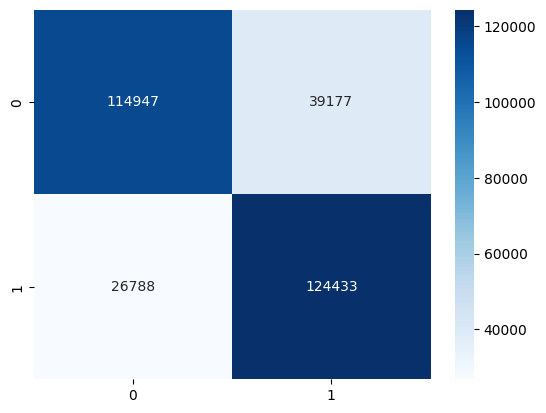

In [45]:
from sklearn.metrics import confusion_matrix
y_preds=[]
for i in range(len(y_pred)) : 
    if y_pred[i]>0.5 :
        y_preds.append(1)
    else:
        y_preds.append(0)
    
cm = confusion_matrix(y_test , y_preds)
sns.heatmap(cm, annot=True,fmt='3g' , cmap="Blues")
plt.show()

In [53]:
from tensorflow.keras.preprocessing.text import one_hot
from unidecode import unidecode
from itertools import filterfalse
import re
import string
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

def preprocess_and_onehot(sentence, vocab_size, corpus, STOPWORDS_FRENCH, stemmer):
    # Convertir en minuscules
    sentence = sentence.lower()
    
    # Supprimer les caractères non alphanumériques
    sentence = re.sub(r'[^a-zA-Z0-9]', ' ', sentence)
    
    # Supprimer les accents
    sentence = unidecode(sentence)
    
    # Supprimer les liens web
    sentence = sentence.replace("https://", "").replace("http://", "")
    
    # Supprimer les noms d'utilisateur
    sentence = sentence.replace("@", "")

    
    # Supprimer les tabulations et les sauts de ligne
    sentence = sentence.translate(str.maketrans("", "", "\t"))
    sentence = sentence.translate(str.maketrans("", "", "\n"))
    
    # Appliquer le stemmer
    sentence = " ".join([stemmer.stem(word) for word in sentence.split()])
    
    # Appliquer one-hot encoding
    onehot_repr = [one_hot(words, vocab_size) for words in [sentence]]
    
    return onehot_repr

# Exemple d'utilisation
vocab_size = 5000
corpus = []  # Assurez-vous d'avoir un corpus défini
STOPWORDS_FRENCH = set(stopwords.words('french'))
stemmer = SnowballStemmer('french')

sentence_to_predict = "Pandri t'aime "
result = preprocess_and_onehot(sentence_to_predict, vocab_size, corpus, STOPWORDS_FRENCH, stemmer)
embedded_docs=pad_sequences(result,padding='post',maxlen=sent_length)
pred=model.predict(embedded_docs)

if pred<0.5:
    print('Le sentiement de la phrase "{}" est négatif. '.format(sentence_to_predict))
else:
    print('Le sentiement de la phrase "{}" est positif. '.format(sentence_to_predict))

1/1 [==============================] - 0s 28ms/step
Le sentiement de la phrase "Pandri t'aime " est positif. 


In [54]:
sentence_to_predict = "Pandri ne t'aime pas "
result = preprocess_and_onehot(sentence_to_predict, vocab_size, corpus, STOPWORDS_FRENCH, stemmer)
embedded_docs=pad_sequences(result,padding='post',maxlen=sent_length)
pred=model.predict(embedded_docs)

if pred<0.5:
    print('Le sentiement de la phrase "{}" est négatif. '.format(sentence_to_predict))
else:
    print('Le sentiement de la phrase "{}" est positif. '.format(sentence_to_predict))

1/1 [==============================] - 0s 26ms/step
Le sentiement de la phrase "Pandri ne t'aime pas " est négatif. 
